In [2]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline

import dataloader
import util

from scipy.optimize import minimize

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#vectorize the images and data
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1]*x_train.shape[2]]).T
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1]*x_test.shape[2]]).T
y_reg_train = y_reg_train.T
y_reg_test = y_reg_test.T

#center the flattened images!
ctr = np.expand_dims(np.mean(x_train, axis=1), axis=1)
x_train = x_train - ctr
x_test = x_test - ctr

#forward model (i.e. simualator)
G = np.load('G.npy')

#parameters
sz = 28
ref = 3
num_samples = 100

#dobs
d_obs = np.squeeze(np.multiply(y_reg_test[:, ref:ref+1], np.expand_dims(dataset.maxs, axis=-1)))
m_ref = np.squeeze(x_test[:, ref:ref+1])

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

print(x_train.shape)
print(x_test.shape)
print(y_reg_train.shape)
print(y_reg_test.shape)
print(G.shape)

print(d_obs.shape)
print(m_ref.shape)

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)
(784, 60000)
(784, 10000)
(128, 60000)
(128, 10000)
(784, 128)
(128,)
(784,)


In [3]:
#run SVD on the matrix of flattened images and construct diag matrix
U, S, VT = np.linalg.svd(x_train, full_matrices=False)
S = np.diag(S)

print(U.shape)
print(S.shape)
print(VT.shape)

#projection (v) on the first k bases
k = 20
phi = U[:, :k]
v = (np.linalg.pinv(phi)@x_test)

#vref
v_ref = np.squeeze(v[:, ref:ref+1])

print(phi.shape)
print(v.shape)
print(v_ref.shape)

(784, 784)
(784, 784)
(784, 60000)
(784, 20)
(20, 10000)
(20,)


In [4]:
#equation to solve
def func(v):
    m = phi@v+np.squeeze(ctr)
    return np.sqrt(np.mean(np.square(G.T@m - d_obs)))

#gradient of the equation
def dldm(v):
    m = phi@v+np.squeeze(ctr)
    return (G@(G.T@m - d_obs))@phi

In [5]:
#callback to monitor optimization process
from IPython.display import clear_output

i = 0
x = []
losses = []
logs = []

def monitor(xk):
    
    global i, x, losses, logs

    fig = plt.figure(figsize=[15, 5])
    logs.append(logs)
    x.append(i)
    losses.append(func(xk))
    i += 1
    clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x, losses, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    plt.subplot(1, 3, 2)
    plt.scatter(v_ref.flatten(), v_ref.flatten(), s=10, color='red', alpha=0.5, label="$v_{ref}$", zorder=20)
    plt.scatter(v_ref.flatten(), xk.flatten(), s=30, color=cs[y_test[ref]], alpha=1.0)
    plt.xlabel("$v_{ref}$")
    plt.ylabel("$v_{sol}$")
    plt.legend()
    plt.title('PCA coeff. Ref vs Solution')

    plt.subplot(1, 3, 3)
    m_sol = np.squeeze(phi@xk)
    plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal', vmin=0, vmax=1)
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model")

    plt.show()
    fig.savefig('readme/grad_pca_dim.png')

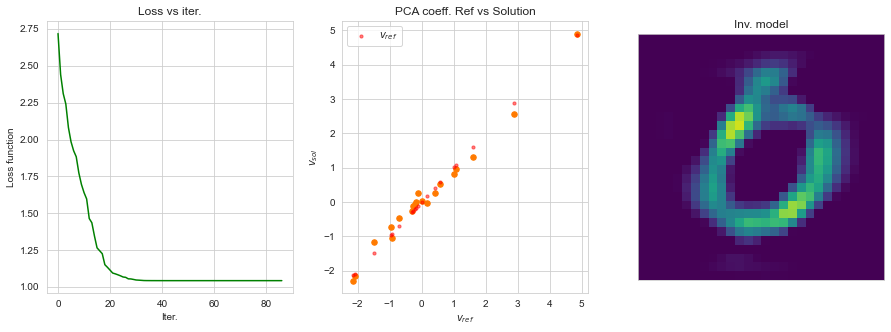

         Current function value: 1.043037
         Iterations: 87
         Function evaluations: 364
         Gradient evaluations: 352
(20,)


In [6]:
#initial guess (sensitive!)
v0 = np.random.normal(size=v_ref.shape)*0.0
print(v0.shape)

#minimize the objective function
res = minimize(func, v0, method='BFGS', jac=dldm, callback=monitor, options={'gtol': 1e-12, 'disp': True})
v_sol = res.x
print(v_sol.shape)

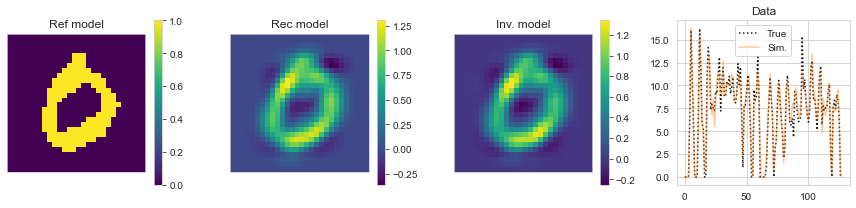

In [7]:
#forward simulation on the inverted model
m_sol = phi@v_sol+np.squeeze(ctr)
y_sim = (m_sol.T@G).T

#compare model and data (i.e. reference case vs solution)
f = plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.imshow(np.reshape(m_ref+np.squeeze(ctr), [sz, sz]), cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")

plt.subplot(1, 4, 2)
plt.imshow(np.reshape(phi@v_ref+np.squeeze(ctr), [sz, sz]), cmap="viridis", aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Rec model")

plt.subplot(1, 4, 3)
plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Inv. model")

plt.subplot(1, 4, 4)
plt.plot(d_obs, ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_sim, c=cs[y_test[ref]], label='Sim.', alpha=0.4)
#plt.ylim([0, 1])
plt.title("Data")
plt.legend()

plt.tight_layout()
f.savefig('readme/grad_pca_dim_comp.png')